# N-gram Model and Its Use in the Code

## What is an N-gram?

- **Unigram**: An n-gram where `n=1`. It consists of single words.
  - Example: `"I love NLP"` → `["I", "love", "NLP"]`
  
- **Bigram**: An n-gram where `n=2`. It consists of pairs of consecutive words.
  - Example: `"I love NLP"` → `["I love", "love NLP"]`
  
- **Trigram**: An n-gram where `n=3`. It consists of triplets of consecutive words.
  - Example: `"I love NLP"` → `["I love NLP"]`

## Purpose of N-grams in NLP

1. **Language Modeling**: N-grams are used to model the likelihood of a word given the previous words in a sequence.
2. **Text Generation**: By training on a corpus of text, an n-gram model can generate text by predicting the next word in a sequence based on the previous `n-1` words.
3. **Perplexity**: A measure used to evaluate how well a language model predicts a sample. Lower perplexity indicates a better model.

## What N-grams are Doing in This Code

1. **Initialization**:
   - The `LanguageModel_NGram` class builds an n-gram model with options for different values of `n`.
   - `is_laplace_smoothing` controls whether Laplace smoothing is applied to handle zero probabilities for unseen n-grams.

2. **Data Loading and Cleaning**:
   - Loads song lyrics from a dataset and preprocesses the text by tokenizing, removing punctuation and stopwords, and converting text to lowercase.

3. **N-gram Tokenization**:
   - The `ngram_tokenization` method generates n-grams from preprocessed sentences.
   - Example: If `n=3`, it creates trigrams from the words in each sentence.

4. **Counting Frequencies**:
   - Counts the frequency of each n-gram and stores this in a dictionary (`ngram_token_count_dict`).
   - Counts the unique occurrences of `(n-1)`-grams to calculate the probabilities of each n-gram.

5. **Training the Model**:
   - The `train` method uses frequency counts to compute the probability of each n-gram.
   - Laplace smoothing adjusts probabilities for unseen n-grams if enabled.

6. **Scoring and Perplexity**:
   - The `score` method calculates the probability of a sentence by multiplying the probabilities of the n-grams in the sentence.
   - The `perplexity` method evaluates how well the model predicts a test sentence, providing a measure of the model's quality.

7. **Text Generation**:
   - The `generate_text` method uses the trained n-gram model to generate text by selecting the most probable next word until a specified length or an end token (`</s>`) is reached.

8. **Evaluation**:
   - The `evaluate_model` method assesses the model's performance by calculating perplexity on training and validation data.

9. **ROUGE Score Calculation**:
   - The `calculate_rouge_score` function computes ROUGE scores to evaluate the quality of generated text by comparing it with reference texts.


#### Step 1 : Imports 

In [1]:
import pandas as pd
import numpy as np
import math
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from rouge_score import rouge_scorer

#### Step 2 : Defining the LamguageModel _NGram Class

In [19]:
class LanguageModel_NGram:
    UNK = "<UNK>"  # Token for unknown words
    SENT_BEGIN = "<s>"  # Token for the beginning of a sentence
    SENT_END = "</s>"  # Token for the end of a sentence

    def __init__(self, n_gram=3, is_laplace_smoothing=1):
        self.n_gram = n_gram  # Set the n-gram size
        self.is_laplace = is_laplace_smoothing  # Set Laplace smoothing flag
        
        # Initialize data structures
        self.data = pd.DataFrame()  # Raw dataset
        self.lyric_dic = {}  # Dictionary to store lyrics by song title
        self.corpus = []  # List to store all lyrics combined
        self.lyric_dic_updated = {}  # Processed lyrics with special tokens
        self.lyric_dic_processed = {}  # Further processed lyrics for n-gram analysis
        self.token_count_dic = {}  # Token frequency dictionary
        self.ngram_token_count_dict = {}  # N-gram token frequency dictionary
        self.total_tokens = 0  # Total number of tokens in the corpus
        self.total_vocab = 0  # Total number of unique tokens in the corpus
        self.unk_words = []  # List to hold rare words considered as unknown tokens
        
        self.prob_dic = {}  # Dictionary to hold probabilities of n-grams
        self.ngram_tokenized_words = []  # List to store tokenized n-grams
        self.unique_tokens_to_count_previous_dic = {}  # Dictionary for unique token counts

    def load_dataset(self, link_to_dataset):
        self.data = pd.read_csv(link_to_dataset, encoding='utf-8')  # Load the dataset into a DataFrame
        print(self.data.head(20))  # Print the first 20 rows of the dataset for inspection
        
    def dataset_cleaning(self):
        lyric_dic = {}  # Initialize a dictionary to store lyrics by song
        corpus = []  # List to store all lyrics
        
        data = self.data  # Reference the dataset
        prev = data["Song Title"].iloc[0]  # Initialize previous song title
        temp = []  # Temporary list to accumulate lyrics for the same song

        # Group lyrics by song title
        for index, rows in data.iterrows():  # Iterate through each row in the DataFrame
            lyrics = rows["Lyrics"]  # Extract lyrics from the current row
            if pd.isna(lyrics):  # Skip rows with missing lyrics
                continue
            corpus.append(lyrics)  # Add lyrics to the corpus
            if prev == rows["Song Title"]:  # Check if current song title matches previous
                temp.append(lyrics)  # Accumulate lyrics for the same song
            else:
                lyric_dic[prev] = temp  # Save accumulated lyrics for the previous song
                prev = rows["Song Title"]  # Update previous song title
                temp = []  # Reset temporary list
                temp.append(lyrics)  # Start accumulating lyrics for the new song
        lyric_dic[prev] = temp  # Add the last accumulated lyrics

        self.lyric_dic = lyric_dic  # Store the lyrics dictionary
        self.corpus = corpus  # Store the combined lyrics corpus

        # Preprocess lyrics for each song
        lyric_dic_updated = {}  # Dictionary to hold preprocessed lyrics
        for song in lyric_dic:  # Iterate through each song
            t_songs = []  # List to hold processed lyrics for a song
            for lyrics in lyric_dic[song]:  # Process each set of lyrics
                t_songs.append(self.preprocess_text(lyrics))  # Preprocess and add to list
            lyric_dic_updated[song] = t_songs  # Save processed lyrics

        self.lyric_dic_updated = lyric_dic_updated  # Store the updated lyrics dictionary

        # Tokenize and preprocess lyrics with special tokens
        lyric_dic_processed = {}  # Dictionary to hold further processed lyrics
        for song_name in lyric_dic_updated:  # Iterate through each song
            temp_array = ["<s>"] * (self.n_gram - 1)  # Add start tokens

            for sentence in lyric_dic_updated[song_name]:  # Process each sentence
                temp = sentence.split()  # Split sentence into words
                temp[-1] = temp[-1] + "/n"  # Append new line token to the last word
                temp_array.extend(temp)  # Add words to the array

            temp_array.extend(["</s>"] * (self.n_gram - 1))  # Add end tokens
            lyric_dic_processed[song_name] = temp_array  # Save processed lyrics
        
        self.lyric_dic_processed = lyric_dic_processed  # Store the processed lyrics dictionary
        
    def preprocess_text(self, text):
        if isinstance(text, str):  # Ensure the text is a string
            text = text.lower()  # Convert text to lowercase
            text = "".join([i for i in text if i not in string.punctuation])  # Remove punctuation
            text = " ".join([i for i in text.split() if i not in stopwords.words('english')])  # Remove stopwords
        else:
            text = ""
        return text
    
    def ngram_tokenization(self, sentences):
        tokens = []  # List to hold n-grams
        for sentence in sentences:  # Iterate through each sentence
            sen = sentence.split()  # Split sentence into words
            for t in range(len(sen) - self.n_gram + 1):  # Generate n-grams
                tokens.append(tuple(sen[t:t + self.n_gram]))  # Add n-gram to list
        return tokens
    
    def count_all_token_freq(self, tokenized_words):
        d = {}  # Dictionary to hold token frequencies
        for token in tokenized_words:  # Iterate through each token
            temp_tuple = tuple(token)  # Convert token to tuple
            if temp_tuple not in d:  # Check if token is already in dictionary
                d[temp_tuple] = 1  # Initialize frequency count
            else:
                d[temp_tuple] += 1  # Increment frequency count
        return d
    
    def count_unique_tokens(self, sentences_from_file):
        word_d = {}  # Dictionary to hold unique token frequencies
        for sen in sentences_from_file:  # Iterate through each sentence
            sen = sen.split()  # Split sentence into words
            for t in range(len(sen) - self.n_gram + 1):  # Generate n-grams
                if self.n_gram == 1:
                    token = tuple(sen[t:t + self.n_gram])  # Create unigram
                else:
                    token = tuple(sen[t:t + self.n_gram - 1])  # Create n-gram of size n-1
                
                if token not in word_d:  # Check if token is already in dictionary
                    word_d[token] = 1  # Initialize frequency count
                else:
                    word_d[token] += 1  # Increment frequency count
        return word_d

    def dataset_preprocess(self):
        token_count_dic = {}  # Dictionary to hold token counts
        count = 0  # Initialize total token count
        for song_name in self.lyric_dic_updated:  # Iterate through each song
            for sentence in self.lyric_dic_updated[song_name]:  # Process each sentence
                for word in sentence.split():  # Split sentence into words
                    if word not in token_count_dic:  # Check if word is already in dictionary
                        token_count_dic[word] = 1  # Initialize frequency count
                    else:
                        token_count_dic[word] += 1  # Increment frequency count
                    count += 1  # Increment total token count
        self.total_tokens = count  # Set total token count
        self.token_count_dic = token_count_dic  # Store token count dictionary

    def display_wordcloud(self):
        text = "".join(self.corpus)  # Combine all lyrics into a single text
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)  # Generate word cloud
        plt.figure(figsize=(10, 5))  # Set figure size for display
        plt.imshow(wordcloud, interpolation='bilinear')  # Display the word cloud
        plt.axis("off")  # Hide axis
        plt.title("Word Cloud of Song Lyrics")  # Set title
        plt.show()  # Show the plot
        
        
    def display_stats_before(self):
        print("Dataset Information before preprocessing")
        corpus = self.corpus  # Reference the corpus
        
        num_of_songs = len(self.lyric_dic)  # Get number of songs
        print("Number of songs =", num_of_songs)

        vocab = set()  # Set to hold unique words
        token_size = 0  # Initialize token size count
        word_count = {}  # Dictionary to hold word frequencies
        
        for sentence in corpus:  # Iterate through each sentence
            tokens = sentence.split()  # Split sentence into words
            vocab.update(tokens)  # Update vocabulary with new words
            token_size += len(tokens)  # Update token size count
            for word in tokens:  # Count word frequencies
                word_count[word] = word_count.get(word, 0) + 1
        
        print("Vocab size =", len(vocab))  # Print vocabulary size
        print("Token size =", token_size)  # Print token size
        
        word_count_cutoff = {k: v for k, v in word_count.items() if v > 50}  # Filter words with frequency > 50
        plt.figure(figsize=(12, 8))  # Set figure size for display
        plt.bar(word_count_cutoff.keys(), word_count_cutoff.values())  # Create bar plot
        plt.xticks(rotation=-45)  # Rotate x-axis labels for better visibility
        plt.title('Word Frequency Cutoff')  # Set title
        plt.show()  # Show the plot
        
        sample_items = list(self.lyric_dic.items())[:1]  # Get a sample song
        print("Sample song lyrics:", sample_items)  # Print the sample song

    def train(self):
        self.total_unique_tokens = len(self.token_count_dic)  # Set total unique token count
        
        for token in self.token_count_dic:  # Iterate through each token
            if self.token_count_dic[token] == 1:  # Check if token occurs only once
                self.unk_words.append(token)  # Add to list of unknown words
        
        all_sentences = []  # List to hold tokenized sentences
        for song_name in self.lyric_dic_processed:  # Iterate through each song
            t = " ".join(self.lyric_dic_processed[song_name])  # Combine tokens into a single string
            all_sentences.append(t)  # Add to list of all sentences
        
        self.ngram_tokenized_words = self.ngram_tokenization(all_sentences)  # Generate n-grams
        self.ngram_token_count_dict = self.count_all_token_freq(self.ngram_tokenized_words)  # Count n-gram frequencies
        self.unique_tokens_to_count_previous_dic = self.count_unique_tokens(all_sentences)  # Count unique n-grams
        
        self.prob_dic = {}  # Dictionary to hold n-gram probabilities
        for token in self.ngram_token_count_dict:  # Iterate through each n-gram
            word = token[:-1]  # Get the prefix of the n-gram
            if self.is_laplace:
                self.prob_dic[token] = (self.ngram_token_count_dict[token] + 1) / (
                            self.unique_tokens_to_count_previous_dic[word] + self.total_unique_tokens)
            else:
                self.prob_dic[token] = self.ngram_token_count_dict[token] / self.unique_tokens_to_count_previous_dic[word]
        
        print("Sample probabilities:", list(self.prob_dic.items())[:10])  # Print sample probabilities

    def score(self, sentence):
        score = 1  # Initialize score
        sen = sentence.split()  # Split sentence into words
        token = ["<s>"] * (self.n_gram - 1)  # Initialize start tokens
        
        for t in range(len(sen)):  # Iterate through each word in the sentence
            token.append(sen[t])  # Add word to token list
            token_temp = tuple(token[t:t + self.n_gram])  # Create n-gram
            if token_temp in self.prob_dic:  # Check if n-gram is in probability dictionary
                score *= self.prob_dic[token_temp]  # Multiply score by n-gram probability
            else:
                score *= 1 / (self.total_unique_tokens + 1)  # Use unknown token probability
        return score  # Return final score
    
    def perplexity(self, sentence):
        sen = sentence.split()  # Split sentence into words
        n = len(sen)  # Get number of words in the sentence
        log_prob_sum = 0  # Initialize sum of log probabilities
        
        token = ["<s>"] * (self.n_gram - 1)  # Initialize start tokens
        for t in range(n):  # Iterate through each word in the sentence
            token.append(sen[t])  # Add word to token list
            token_temp = tuple(token[t:t + self.n_gram])  # Create n-gram
            if token_temp in self.prob_dic:  # Check if n-gram is in probability dictionary
                log_prob_sum += math.log(self.prob_dic[token_temp])  # Add log probability
            else:
                log_prob_sum += math.log(1 / (self.total_unique_tokens + 1))  # Use log of unknown token probability
        
        perplexity = math.exp(-log_prob_sum / n)  # Calculate perplexity
        return perplexity  # Return perplexity
    
    def generate_text(self, max_length=100):
        """
        Generate text using the trained n-gram model.

        :param max_length: Maximum length of the generated text
        :return: Generated text
        """
        current_tokens = ["<s>"] * (self.n_gram - 1)  # Start with sentence start tokens
        generated_text = []

        for _ in range(max_length):
            current_ngram = tuple(current_tokens[-(self.n_gram - 1):])  # Get the current n-gram prefix
            possible_next_tokens = [token for token in self.prob_dic if token[:-1] == current_ngram]  # Find possible next tokens

            if not possible_next_tokens:
                break  # No possible next token, end generation

            next_token = max(possible_next_tokens, key=lambda token: self.prob_dic[token])[-1]  # Select the most probable next token
            if next_token == "</s>":
                break  # End token reached, stop generation

            generated_text.append(next_token)  # Add the next token to the generated text
            current_tokens.append(next_token)  # Update the current tokens

        return " ".join(generated_text)
    
    def evaluate_model(self, train_sizes, validation_data):
        train_perplexities = []
        validation_perplexities = []
        
        for train_size in train_sizes:
            train_data = self.data.sample(frac=train_size, random_state=42)
            self.data = train_data
            self.dataset_cleaning()
            self.dataset_preprocess()
            self.train()

            train_corpus = " ".join(train_data["Lyrics"].dropna().tolist())
            train_sentences = train_corpus.split("\n")
            train_perplexity = np.mean([self.perplexity(sentence) for sentence in train_sentences if sentence.strip()])
            train_perplexities.append(train_perplexity)

            validation_corpus = " ".join(validation_data["Lyrics"].dropna().tolist())
            validation_sentences = validation_corpus.split("\n")
            validation_perplexity = np.mean([self.perplexity(sentence) for sentence in validation_sentences if sentence.strip()])
            validation_perplexities.append(validation_perplexity)
        
        return train_perplexities, validation_perplexities

# Function to calculate ROUGE score
def calculate_rouge_score(generated_text, reference_texts):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = []

    for reference_text in reference_texts:
        score = scorer.score(reference_text, generated_text)
        scores.append(score)

    avg_scores = {}
    for key in scores[0].keys():
        avg_scores[key] = {
            'precision': np.mean([score[key].precision for score in scores]),
            'recall': np.mean([score[key].recall for score in scores]),
            'fmeasure': np.mean([score[key].fmeasure for score in scores])
        }
    
    return avg_scores

#### Step 3 : Load and Train the Model

In [15]:
# Load the dataset, train the model, and evaluate overfitting/underfitting
lm = LanguageModel_NGram()
lm.load_dataset("ed_sheeran_cleaned_songs.csv")  # Load your dataset here



                                  Song Title  \
0            \nShe Looks So Perfect Lyrics\n   
1                    \nShape of You Lyrics\n   
2                         \nPerfect Lyrics\n   
3                      \nPhotograph Lyrics\n   
4               \nThinking Out Loud Lyrics\n   
5                         \nHappier Lyrics\n   
6                          \nA Team Lyrics\n   
7                      \nI See Fire Lyrics\n   
8             \nSupermarket Flowers Lyrics\n   
9              \nCastle on the Hill Lyrics\n   
10                   \nGive Me Love Lyrics\n   
11                   \nPerfect Duet Lyrics\n   
12                          \nDon't Lyrics\n   
13               \nAll Of The Stars Lyrics\n   
14               \nPerfect Symphony Lyrics\n   
15                        \nKiss Me Lyrics\n   
16                           \nDive Lyrics\n   
17  \nYou Need Me, I Don't Need You Lyrics\n   
18                     \nLego House Lyrics\n   
19                   \nTenerife Sea Lyri


#### Displaying the word Cloud

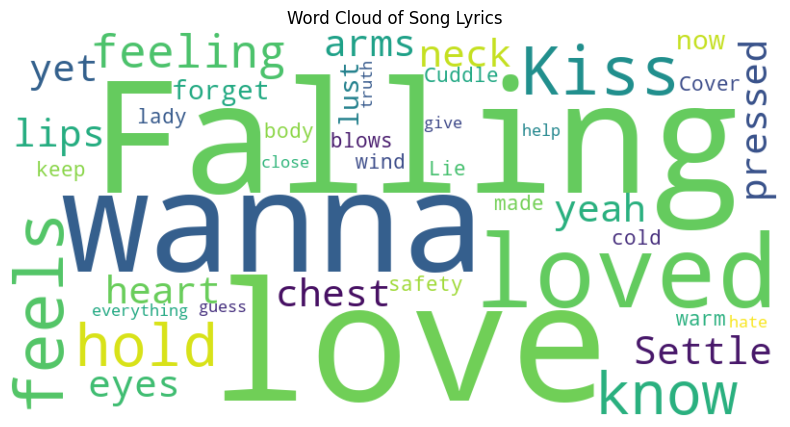

In [8]:
# 3. Display word cloud
lm.display_wordcloud()

#### Step 4 : Train the model

In [21]:
# 5. Train the language model
lm.train()

Sample probabilities: [(('<s>', '<s>', 'settle'), 0.041666666666666664), (('<s>', 'settle', 'cover'), 0.041666666666666664), (('settle', 'cover', 'cuddle'), 0.041666666666666664), (('cover', 'cuddle', 'lie'), 0.041666666666666664), (('cuddle', 'lie', 'yeah'), 0.041666666666666664), (('lie', 'yeah', 'hold'), 0.041666666666666664), (('yeah', 'hold', 'arms'), 0.041666666666666664), (('hold', 'arms', 'hearts'), 0.061224489795918366), (('arms', 'hearts', 'chest'), 0.061224489795918366), (('hearts', 'chest', 'lips'), 0.061224489795918366)]


In [22]:
# Generate new text
generated_text = lm.generate_text(max_length=1000)
print("Generated Text:", generated_text)



Generated Text: settle cover cuddle lie yeah hold arms hearts chest lips pressed neck im falling eyes dont know yet feeling ill forget im love kiss like wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna loved wanna l

#### Step 5 : Model Evaluation

#### Rouge Score

In [29]:
from rouge_score import rouge_scorer

# Example reference and generated texts
reference = "Oh darling, Settle down with me, Cover me up, Cuddle me in, Oh, maybe I came on too strong, Maybe I waaited, Now I'm in town, break it down,"
generated = "settle cover cuddle lie yeah hold arms hearts chest lips pressed neck im falling eyes dont know yet feeling ill forget im love kiss"

# Tokenize the reference and generated texts
reference_tokens = [reference.lower().split()]
generated_tokens = generated.lower().split()

# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate the ROUGE scores
scores = scorer.score(reference, generated)

# Display the ROUGE scores
print("ROUGE-1: Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(
    scores['rouge1'].precision, scores['rouge1'].recall, scores['rouge1'].fmeasure))

print("ROUGE-2: Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(
    scores['rouge2'].precision, scores['rouge2'].recall, scores['rouge2'].fmeasure))

print("ROUGE-L: Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(
    scores['rougeL'].precision, scores['rougeL'].recall, scores['rougeL'].fmeasure))


ROUGE-1: Precision: 0.1250, Recall: 0.1000, F1: 0.1111
ROUGE-2: Precision: 0.0000, Recall: 0.0000, F1: 0.0000
ROUGE-L: Precision: 0.1250, Recall: 0.1000, F1: 0.1111


#### Bleu Score

In [30]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Calculate the BLEU score
smoothie = SmoothingFunction().method4  # Using smoothing method4 to avoid zero BLEU scores
bleu_score = sentence_bleu(reference_tokens, generated_tokens, smoothing_function=smoothie)

# Display the BLEU score
print(f"BLEU score: {bleu_score:.4f}")


BLEU score: 0.0120


#### Cosine Similarity 

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# Create a TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Vectorize the texts
tfidf_matrix = vectorizer.fit_transform([reference, generated])

# Calculate cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])

# Display the cosine similarity score
print(f"Cosine Similarity: {cosine_sim[0][0]:.4f}")


Cosine Similarity: 0.0494


In [33]:
# Example: Checking for underfitting and overfitting using perplexity

train_perplexities = []  # To store training perplexities
validation_perplexities = []  # To store validation perplexities

for train_index, test_index in kf.split(data):
    train_data = data.iloc[train_index]
    validation_data = data.iloc[test_index]

    # Assign train data to the model and preprocess
    lm.data = train_data
    lm.dataset_cleaning()
    lm.dataset_preprocess()
    lm.train()

    # Calculate perplexity on the training set
    train_corpus = " ".join(train_data["Lyrics"].dropna().tolist())
    train_sentences = train_corpus.split("\n")
    train_perplexity = np.mean([lm.perplexity(sentence) for sentence in train_sentences if sentence.strip()])
    train_perplexities.append(train_perplexity)

    # Calculate perplexity on the validation set
    validation_corpus = " ".join(validation_data["Lyrics"].dropna().tolist())
    validation_sentences = validation_corpus.split("\n")
    validation_perplexity = np.mean([lm.perplexity(sentence) for sentence in validation_sentences if sentence.strip()])
    validation_perplexities.append(validation_perplexity)

    print(f"Fold Train Perplexity: {train_perplexity:.4f}")
    print(f"Fold Validation Perplexity: {validation_perplexity:.4f}")

# Calculate average perplexity across all folds
average_train_perplexity = np.mean(train_perplexities)
average_validation_perplexity = np.mean(validation_perplexities)
print(f"Average Train Perplexity: {average_train_perplexity:.4f}")
print(f"Average Validation Perplexity: {average_validation_perplexity:.4f}")


Sample probabilities: [(('<s>', '<s>', 'hey'), 0.0007122507122507123), (('<s>', 'hey', 'hey'), 0.0007377351530800443), (('hey', 'hey', 'hey'), 0.016678752719361856), (('hey', 'hey', 'simmer'), 0.0007251631617113851), (('hey', 'simmer', 'simmer'), 0.0007377351530800443), (('simmer', 'simmer', 'say'), 0.0007377351530800443), (('simmer', 'say', 'young'), 0.0007377351530800443), (('say', 'young', 'amount'), 0.0007377351530800443), (('young', 'amount', 'anything'), 0.0007377351530800443), (('amount', 'anything', 'else'), 0.0007377351530800443)]
Fold Train Perplexity: 2676.0723
Fold Validation Perplexity: 2673.2445
Sample probabilities: [(('<s>', '<s>', 'hey'), 0.0007393715341959334), (('<s>', 'hey', 'hey'), 0.0007662835249042146), (('hey', 'hey', 'hey'), 0.017312758750470454), (('hey', 'hey', 'simmer'), 0.0007527286413248024), (('hey', 'simmer', 'simmer'), 0.0007662835249042146), (('simmer', 'simmer', 'say'), 0.0007662835249042146), (('simmer', 'say', 'young'), 0.0007662835249042146), (('sa

#### 1. **Underfitting:**
If both average_train_perplexity and average_validation_perplexity are high, your model might be underfitting.
Solution: Increase model complexity by adding more features, increasing n-gram size, or reducing regularization.
#### 2. **Overfitting:**
If average_train_perplexity is low and average_validation_perplexity is significantly higher, your model might be overfitting.
Solution: Apply regularization (e.g., Laplace smoothing), reduce model complexity, or use more training data.
#### 3. **Good Fit:**
If both average_train_perplexity and average_validation_perplexity are low and close to each other, your model is likely well-balanced.


#### Training and Validation Perplexities:
##### Average Train Perplexity: 2701.0551
##### Average Validation Perplexity: 2711.4854



### Analysis 
Similar Perplexity Values: The training and validation perplexities are very close to each other across all the folds, with the difference being relatively small.
High Perplexity Values: The values themselves are quite high, indicating that the model might struggle to predict the next word in the sequence, which could suggest a challenging dataset or a model that's not highly effective.



#### Underfitting or Overfitting?
1. Underfitting: Since both the training and validation perplexity values are high and close to each other, this suggests that the model might be underfitting. Underfitting happens when the model is too simple to capture the underlying patterns in the data, resulting in poor performance on both the training and validation sets.
2. Overfitting: Overfitting would be indicated by a much lower training perplexity compared to validation perplexity. However, the values are similar, so overfitting is not the primary concern here.